####Mood Tracker Pipelines

allows users to log their **daily experiences in various languages**, classify their mood based on their text entries, and receive motivational messages. The project utilizes a combination of **Hugging Face pipelines**, **OpenAI GPT-3.5-turbo API**, and **Gradio** for a seamless and interactive user interface.


In this notebook, we will demonstrate the pipelines: how they work, their inputs, and their outputs.


**Authors :**


Shahad Mousa Albalawi
& Nojood Mohammed Alnahdi

####Dependencies

In [17]:
!pip install openai

In [18]:
!pip install -q python-dotenv==1.0.0

In [19]:
from transformers import pipeline
import pandas as pd
from openai import OpenAI
import matplotlib.pyplot as plt
from dotenv import dotenv_values

#### Text Classification Hugging Face Pipeline

In [20]:
#This is a model for a multi-label classification task that classifies text into different emotions. It works only in English.
classifier = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
# simple test for inputs and outputs of the pipeline
result = classifier("I am so happy")
label_result = result[0]['label']
print(f'Result of the pipeline : {result}')
print(f'result of only the label : {label_result}')

Result of the pipeline : [{'label': 'joy', 'score': 0.9051513671875}]
result of only the label : joy


#### Translation Hugging Face Pipeline

In [22]:
# This is a model for a translation task, designed to translate text.
# We use it to translate any non-English text into English, so the classifier can then classify the emotions.

translator = pipeline(task="translation", model="facebook/nllb-200-distilled-600M")
languages = {
    "English": "eng_Latn",
    "French": "fra_Latn",
    "Arabic": "arb_Arab",
    "Spanish": "spa_Latn",
    "German": "deu_Latn",
    "Chinese": "zho_Hans",
    "Hindi": "hin_Deva"
}

In [23]:
# simple test for inputs and outputs of the pipeline
result = translator("así es la vida", src_lang=languages['Spanish'], tgt_lang= languages["French"])
translated_text = result[0]['translation_text']
print(f'Result of the pipeline : {result}')
print(f'result of only the translated text : {translated_text}')

Result of the pipeline : [{'translation_text': "C'est comme ça que la vie est"}]
result of only the translated text : C'est comme ça que la vie est


#### openAI API

In [24]:
# prepare openAI client with our api key
env_values = dotenv_values("./app.env")
client = OpenAI(
    api_key= env_values['OPENAI_API_KEY'],)

In [25]:
# simple test for client of openAI
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say hello!",
        }
    ],
    model="gpt-3.5-turbo",
)

content_only = chat_completion.choices[0].message.content
print(f'Result : {chat_completion}')
print(f'result of only the content : {content_only}')

Result : ChatCompletion(id='chatcmpl-A6jKXsC5NicUVKCbdbo6CCOshUTvI', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', refusal=None, role='assistant', function_call=None, tool_calls=None))], created=1726167581, model='gpt-3.5-turbo-0125', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=9, prompt_tokens=10, total_tokens=19))
result of only the content : Hello! How can I assist you today?


#### Dataframe using pandas

In [26]:
# Create a DataFrame to store user entries and perform analysis.

structure = {
    'Date': [],
    'Text': [],
    'Mood': []
}
df = pd.DataFrame(structure)

#### Putting it all together

In [27]:
# Take the text and its source language, translate it to English, so that the classifier can perform the task.
def translator_text(text, src_lang):
  translation = translator(text, src_lang=src_lang, tgt_lang="eng_Latn")
  return translation[0]['translation_text']

In [28]:
# Take all the inputs from the user, including the mood (result from the classifier), and append them to the DataFrame.
def appender(date, text, mood):
  global df
  new_row = pd.DataFrame({'Date': [date], 'Text': [text], 'Mood': [mood]})
  df = pd.concat([df, new_row], ignore_index=True)

In [29]:
#Taking input entries from user
date = input("Enter Date (YYYY-MM-DD): ")
src_lang = input("Select a Language (English, French, Arabic, Spanish, German, Chinese, Hindi): ") #
text = input("What's happened today? ")

#translator pipeline
if src_lang!= 'English':
  text = translator_text(text, languages[src_lang])

#Classifier pipeline
mood = classifier(text)[0]['label']

#openAI client
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": f"I feel{mood}, can you tell me a message, without any introductory phrase, just the message itself.",
        }
    ],
    model="gpt-3.5-turbo",
)

#append to dataframe
appender(date, text, mood)

#output messages
print(f"Today you're feeling {mood}")
print(chat_completion.choices[0].message.content)

Enter Date (YYYY-MM-DD): 2024-09-12
Select a Language (English, French, Arabic, Spanish, German, Chinese, Hindi): English
What's happened today? I feel happy
Today you're feeling joy
You are capable of achieving amazing things. Believe in yourself and never give up.


In [30]:
# our DataFrame
df

,Date,Text,Mood
0,2024-09-12,I feel happy,joy


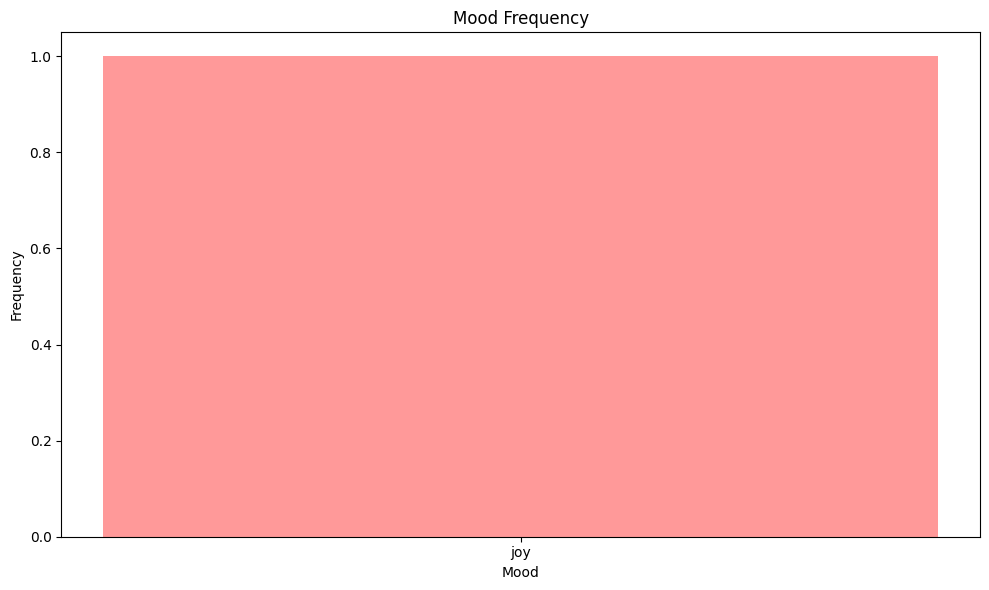

In [31]:
# visulize utilize matplot
mood_counts = df['Mood'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(mood_counts.index, mood_counts.values, color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
plt.title('Mood Frequency')
plt.xlabel('Mood')
plt.ylabel('Frequency')
plt.tight_layout()

plt.show()